## load dataset:
loading dataset from google drive extracting zip file

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#changing the working directory
%cd /content/gdrive/MyDrive/kaggle
#Check the present working directory using pwd command

/content/gdrive/MyDrive/kaggle


In [3]:
%cp flickr8k.zip /content

In [4]:
%cd /content

/content


In [5]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

 in this notebook tips of this
 [video](https://www.youtube.com/watch?v=y2BaTt1fxJU)

## Preprocessing
- read data
- create vocabulary
- create custom dataset
- apply padding

In [8]:
#imports 
import os
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from nltk.tokenize import RegexpTokenizer #for tokenizer
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### reading data
captions and images file names

In [7]:
#reading the text data 
import pandas as pd
caption_file = 'captions.txt'
df = pd.read_csv(caption_file)
print(f"There are {len(df)} image to captions")
df.head(10)

There are 40455 image to captions


image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...
5  1001773457_577c3a7d70.jpg         A black dog and a spotted dog are fighting
6  1001773457_577c3a7d70.jpg  A black dog and a tri-colored dog playing with...
7  1001773457_577c3a7d70.jpg  A black dog and a white dog with brown spots a...
8  1001773457_577c3a7d70.jpg  Two dogs of different breeds looking at each o...
9  1001773457_577c3a7d70.jpg    Two dogs on pavement moving toward each other .

### build vocabulary

In [9]:
class Vocabulary:
  def __init__(self, freq_threshold):
    self.itos = {0:"<PAD>" , 1:"<SOS>", 2:"<EOS>", 3:"<UNT>"}
    self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNT>":3}
    self.freq_threshold = freq_threshold


  def __len__(self):
    return len(self.itos)

  def tokenizer(self, text):
    tokenizer = RegexpTokenizer(r'\w+')
    return [token.lower() for token in tokenizer.tokenize(text)]
  
  def build_vocab(self, caption_list):
    fequencies = {}
    idx = 4

    for caption in caption_list:
      for token in self.tokenizer(caption):
        if token not in fequencies:
          fequencies[token] = 1
        else:
          fequencies[token] += 1
        if fequencies[token] == self.freq_threshold:
          self.stoi[token] = idx
          self.itos[idx] = token
          idx += 1
    
  def numericalize(self, text):
    tokenized_text = self.tokenizer(text)

    return [self.stoi[token] if token in self.stoi else self.stoi["<UNT>"] for token in tokenized_text]


In [10]:
#testing the vocab class 
v = Vocabulary(freq_threshold=1)
v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNT>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3]


### creeate custom dataset

In [11]:
class FlickrDataset(Dataset):
  def __init__(self, root_dir, caption, transform=None, freq_threshold=5,data_type='train'):
    data_frame = pd.read_csv(caption)
    if data_type == 'train':
      self.df = df.iloc[:int(0.9*len(df))]
    elif data_type == 'test':
      self.df = df.iloc[int(0.9*len(df)):].reset_index(drop=True)
    else:
      pass
    self.root_dir =root_dir
    self.transform = transform

    # images and caption of each image
    self.imgs = self.df['image']
    self.captions= self.df['caption']

    # Initialize vocabulary and build vocab
    self.vocab = Vocabulary(freq_threshold)
    self.vocab.build_vocab(self.captions.tolist())

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    caption = self.captions[index]
    image_name = self.imgs[index]
    image_path = self.root_dir + '/' +image_name
    img = Image.open(image_path).convert("RGB")

    if self.transform is not None:
      img = self.transform(img)

    vectorized_caption = [self.vocab.stoi["<SOS>"]]
    vectorized_caption += self.vocab.numericalize(caption)
    vectorized_caption.append(self.vocab.stoi["<EOS>"])
    return img, torch.tensor(vectorized_caption)

### test dataset and plot some samples of data

In [12]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

#testing the dataset class
train_dataset =  FlickrDataset(
    root_dir = "/content/Images",
    caption =  "captions.txt",
    transform=transforms,
    data_type = 'train'
)

test_dataset =  FlickrDataset(
    root_dir = "/content/Images",
    caption =  "captions.txt",
    transform=transforms,
    data_type = 'test'
)

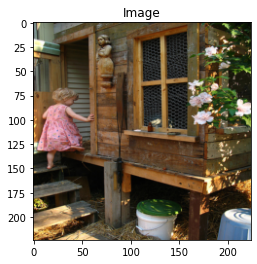

Token: tensor([  1,   4,  27,   7,   4, 192, 148,  16,  31,  65,   4, 350,  10, 707,
          7,  23,   3, 492,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNT>', 'way', '<EOS>']


In [15]:
img, caps = train_dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([train_dataset.vocab.itos[token] for token in caps.tolist()])

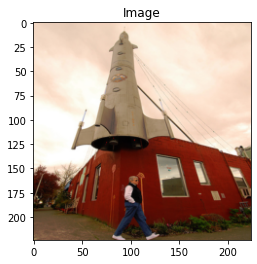

Token: tensor([  1,   4,  58,  18,  14,   4,  29,  88,   5,   4,   3,   9, 108,  10,
        130,   2])
Sentence:
['<SOS>', 'a', 'person', 'walking', 'by', 'a', 'red', 'building', 'with', 'a', '<UNT>', 'on', 'top', 'of', 'it', '<EOS>']


In [16]:
img, caps = test_dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([test_dataset.vocab.itos[token] for token in caps.tolist()])

### apply padding for sentences of each batch

In [17]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,captions

### test dataloaders with padding

In [18]:

BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = train_dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

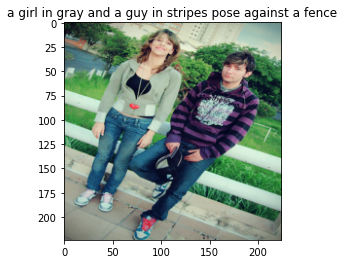

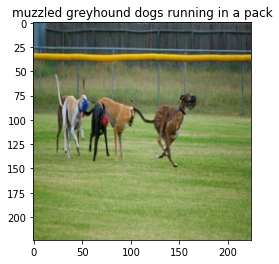

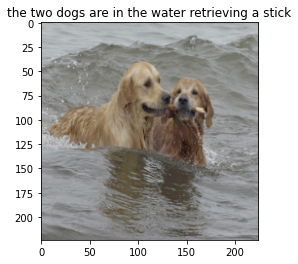

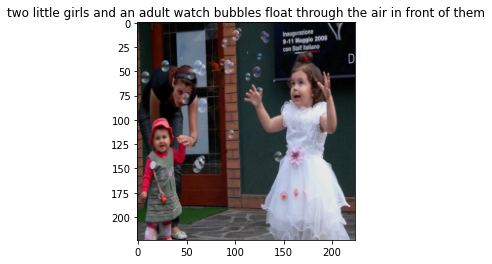

In [19]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [train_dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

---------------------------------------------

## create image captioning model
- create train  dataloaders
- create  model
- train model for some epochs
- test and evaluate model

In [20]:
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


In [21]:
#for image plot when testing the model
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    # back to unnormalized form
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] +=  0.406
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## part A)

### create dataloaders

In [22]:
BATCH_SIZE = 256
NUM_WORKER = 2
pad_idx = train_dataset.vocab.stoi["<PAD>"]

#defining the transform to be applied using resnet normalization and random crops
transforms = T.Compose([
    T.Resize(256),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
train_dataset =  FlickrDataset(
    root_dir = "/content/Images",
    caption = "captions.txt",
    transform=transforms,
    data_type = 'train'
)


#writing the dataloader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)


### create model

### pre-trained resnet for feature extractions (finetune last linear)

In [23]:
class ResNet(nn.Module):
    def __init__(self, embed_size,train_resnet = False):
        super(ResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(train_resnet)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.dropout(self.relu(self.resnet(images)))
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


### LSTM network

In [25]:

class LSTM(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_size,vocab_size)
        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.dropout(self.embedding(captions[:,:-1]))
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.linear(x)
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.linear(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]
        


### combining resnet and lstm for image captining

In [26]:
           
class CNNtoRNN(nn.Module):
  def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.5,train_resnet=False):
    super().__init__()
    self.encoder = ResNet(embed_size,train_resnet)
    self.decoder = LSTM(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs


### train Network for some epoch

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [55]:
# Hyperparameters
embed_size = 128
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 3e-4

In [56]:
# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers,train_resnet=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 25
train_loss = []
for epoch in range(num_epochs):
  running_loss = 0
  #print_examples(model, device, dataset)
  for idx, (image, captions) in enumerate(iter(train_loader)):
    image,captions = image.to(device),captions.to(device)
    model.train()
    optimizer.zero_grad()
    # Feed forward
    outputs = model(image, captions)
    # Calculate the batch loss.
    loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
    # Backward pass.
    loss.backward()
    # Update the parameters in the optimizer.
    optimizer.step()   
    running_loss += loss.item()

  print(f'epoch: {epoch} -  train loss: {running_loss / (idx+1)} ')
  train_loss.append(running_loss / (idx+1))
  torch.save(model.cpu().state_dict(), 'final_model.pth') # saving model
  model.cuda()

print('training Finished!')

epoch: 0 -  train loss: 5.298244109520545 
epoch: 1 -  train loss: 4.188735995259318 
epoch: 2 -  train loss: 3.89190965932566 
epoch: 3 -  train loss: 3.714044075745803 
epoch: 4 -  train loss: 3.586438199023267 
epoch: 5 -  train loss: 3.4714287227683966 
epoch: 6 -  train loss: 3.3826117982397546 
epoch: 7 -  train loss: 3.308256676147034 
epoch: 8 -  train loss: 3.245137314696412 
epoch: 9 -  train loss: 3.1898295562584082 
epoch: 10 -  train loss: 3.14018667827953 
epoch: 11 -  train loss: 3.0989908771915036 
epoch: 12 -  train loss: 3.060507834374488 
epoch: 13 -  train loss: 3.02475739359022 
epoch: 14 -  train loss: 2.994117666791369 
epoch: 15 -  train loss: 2.964920869240394 
epoch: 16 -  train loss: 2.9374003410339355 
epoch: 17 -  train loss: 2.9145378582961077 
epoch: 18 -  train loss: 2.889658916246641 
epoch: 19 -  train loss: 2.867055764565101 
epoch: 20 -  train loss: 2.8461051854220303 
epoch: 21 -  train loss: 2.8253869160071954 
epoch: 22 -  train loss: 2.8055787920

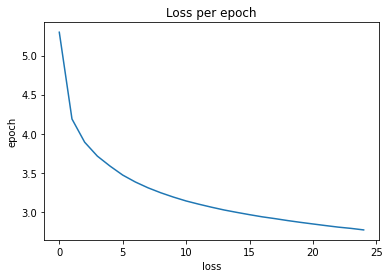

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("loss")
plt.ylabel("epoch")
plt.plot(train_loss)

### test and evaluate Network

#### create test dataloader

In [103]:
test_transforms = T.Compose([
    T.Resize((224,224)),                
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
test_dataset =  FlickrDataset(
    root_dir = "/content/Images",
    caption = "captions.txt",
    transform=test_transforms,
    freq_threshold = 1,
    data_type = 'test'
)


test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [104]:
i1, l1 = next(iter(test_loader))


#### test model

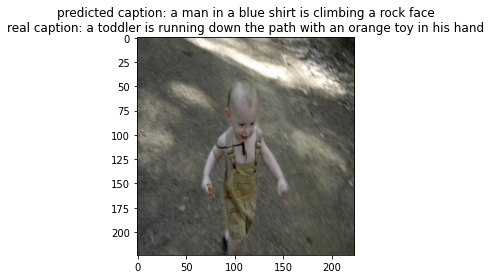

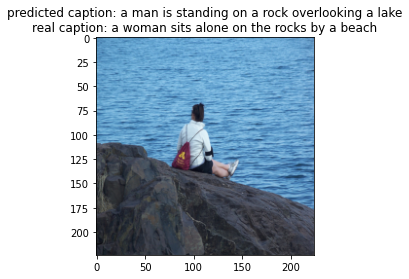

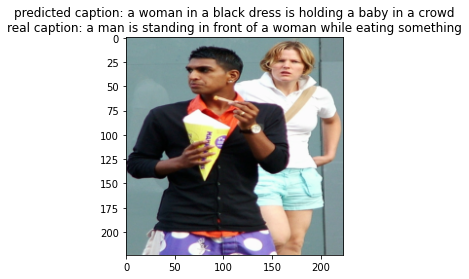

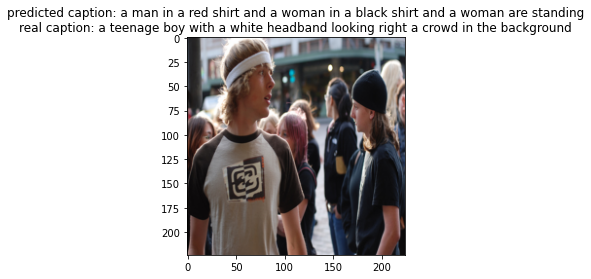

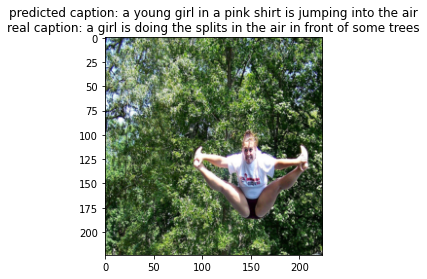

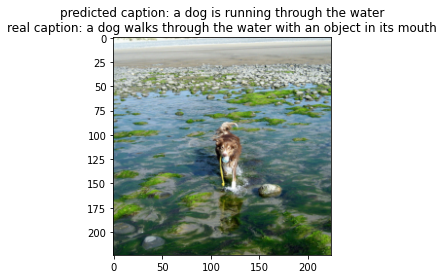

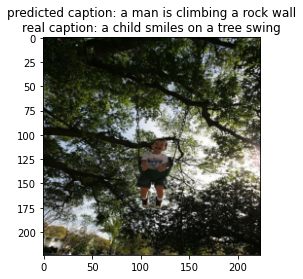

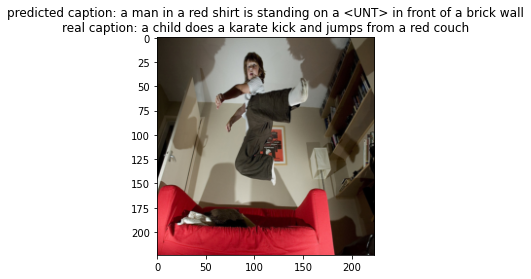

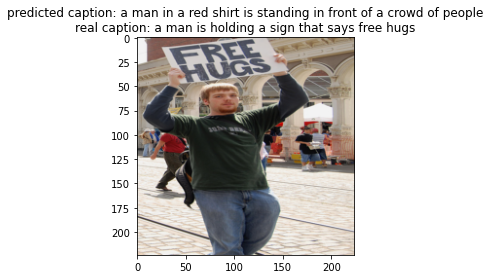

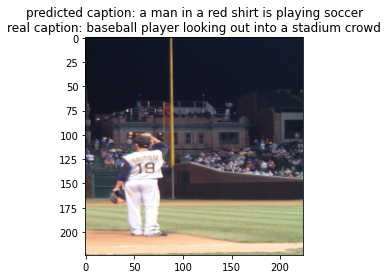

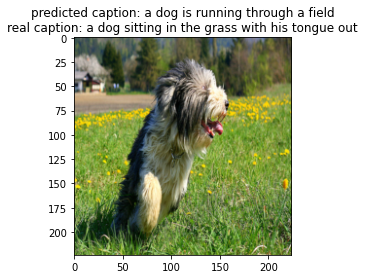

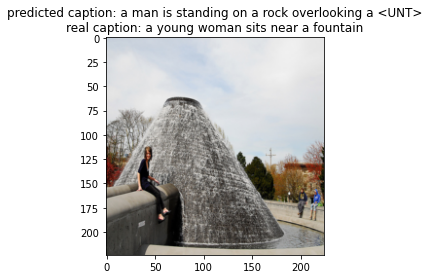

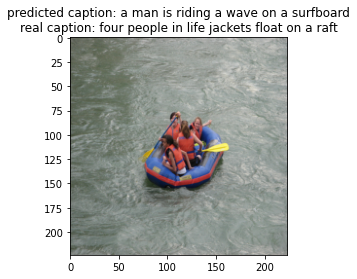

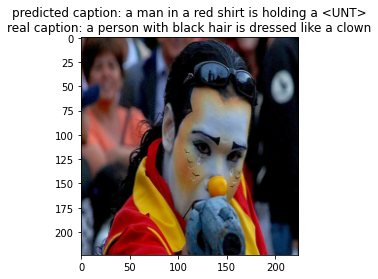

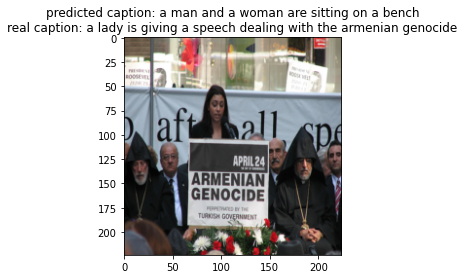

In [105]:
for i in range(15):
  model.eval()
  test_img = torch.clone(i1)[i].unsqueeze(0)
  with torch.no_grad():
    features = model.encoder(test_img[0:1].to(device))
    caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=train_dataset.vocab)
    cap = torch.clone(l1)[i]
    caption_label = [test_dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)  
    caption = "predicted caption: "+ ' '.join(caps[1:len(caps)-1]) + '\n' + "real caption: " + caption_label
    show_image(test_img[0],title=caption)

## part B)

### training image captioning model without freezing Resnet
> using train dataloader and model calsses of part A

### train model for some epochs

In [106]:
# Hyperparameters
embed_size = 128
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 3e-4


In [107]:
# initialize model, loss etc
model_notfreeze = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers,train_resnet=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model_notfreeze.parameters(), lr=learning_rate)

In [ ]:
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()
num_epochs = 25
train_loss_train = []
for epoch in range(num_epochs):
  running_loss = 0
  #print_examples(model, device, dataset)
  for idx, (image, captions) in enumerate(iter(train_loader)):
    image,captions = image.to(device),captions.to(device)
    model_notfreeze.train()
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
    # Feed forward
      outputs = model_notfreeze(image, captions)
      # Calculate the batch loss.
      loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
      # Backward pass.
      scaler.scale(loss).backward()
    # Update the parameters in the optimizer.
      scaler.step(optimizer) 
      scaler.update() 
      running_loss += loss.item()
  
  print(f'epoch: {epoch} -  train loss: {running_loss / (idx+1)} ')
  train_loss_train.append(running_loss / (idx+1))
  torch.save(model_notfreeze.cpu().state_dict(), 'final_model_resnet.pth') # saving model
  model_notfreeze.cuda()

print('training Finished!')

epoch: 0 -  train loss: 5.295861811071009 
epoch: 1 -  train loss: 4.225809969268479 
epoch: 2 -  train loss: 3.917138594847459 
epoch: 3 -  train loss: 3.73136139749647 
epoch: 4 -  train loss: 3.597372358495539 
epoch: 5 -  train loss: 3.482263129907888 
epoch: 6 -  train loss: 3.383812785982252 
epoch: 7 -  train loss: 3.3036608979418562 
epoch: 8 -  train loss: 3.231843016364358 
epoch: 9 -  train loss: 3.1691719451984324 
epoch: 10 -  train loss: 3.114627516353047 
epoch: 11 -  train loss: 3.063958773246178 
epoch: 12 -  train loss: 3.0195568824981476 
epoch: 13 -  train loss: 2.975775573637102 
epoch: 14 -  train loss: 2.9351345042248704 
epoch: 15 -  train loss: 2.901076948726094 
epoch: 16 -  train loss: 2.865469989243087 
epoch: 17 -  train loss: 2.8339746081745707 
epoch: 18 -  train loss: 2.8021303190217983 
epoch: 19 -  train loss: 2.775371017989579 
epoch: 20 -  train loss: 2.7481353549690515 
epoch: 21 -  train loss: 2.7235988536914744 
epoch: 22 -  train loss: 2.69727211

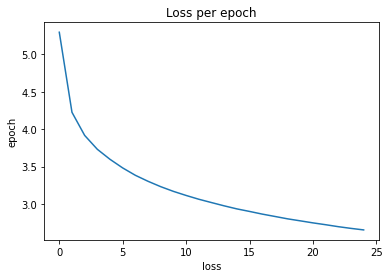

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("loss")
plt.ylabel("epoch")
plt.plot(train_loss_train)

### test and evaluate model

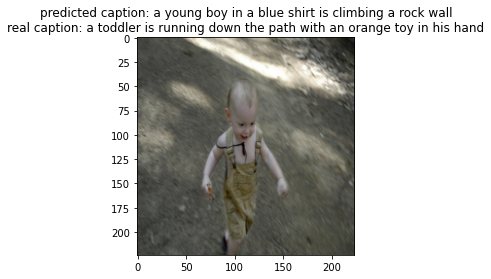

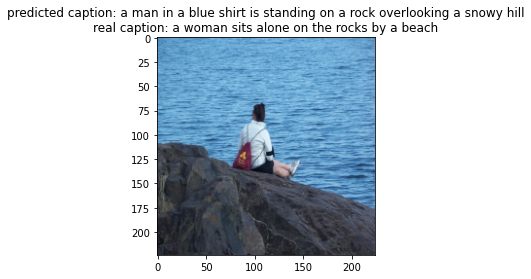

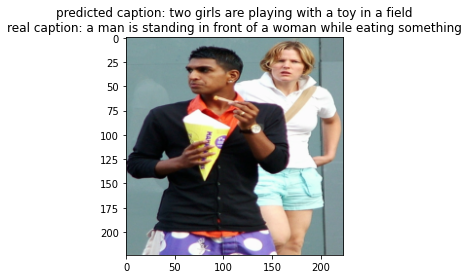

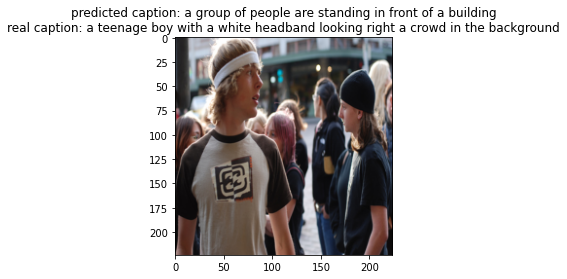

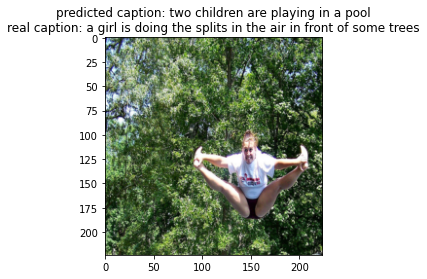

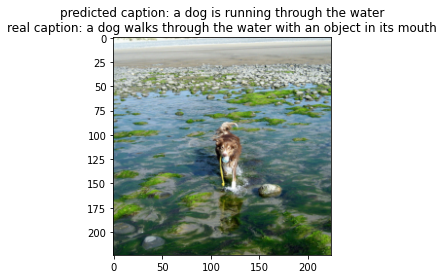

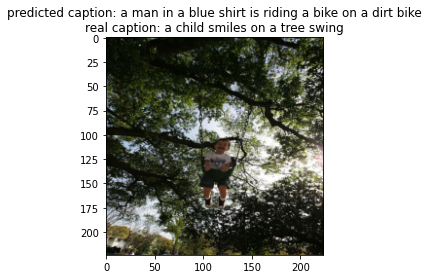

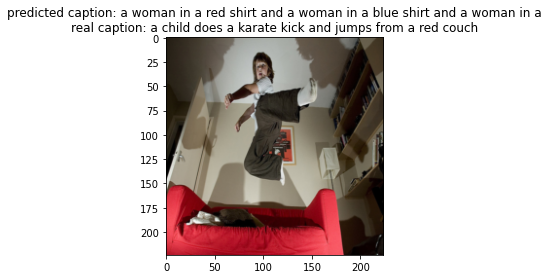

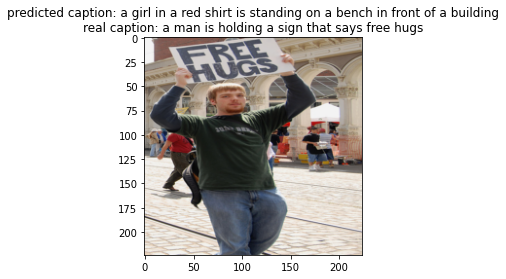

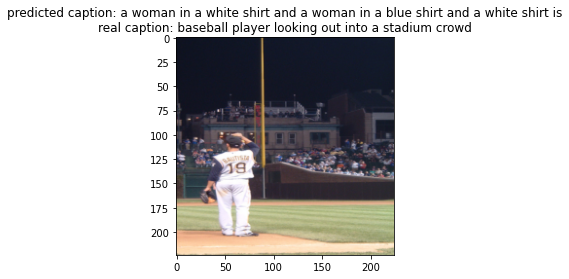

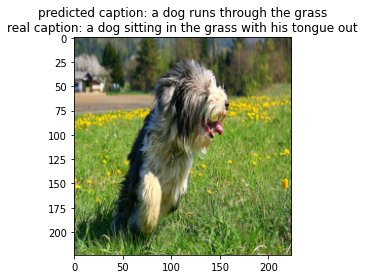

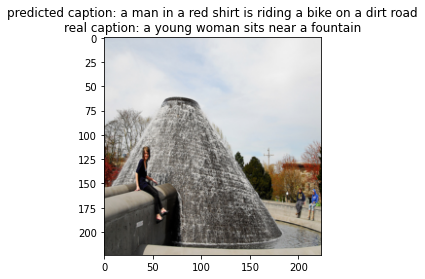

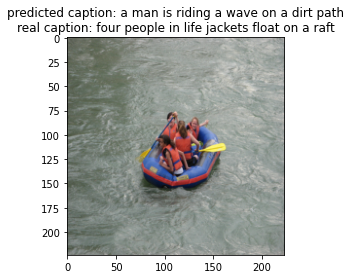

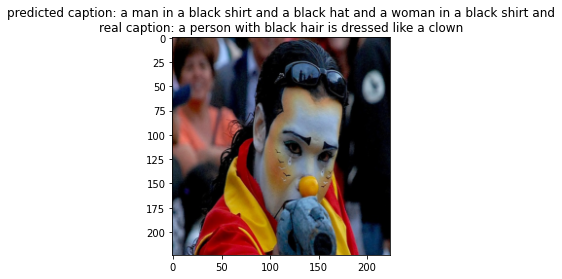

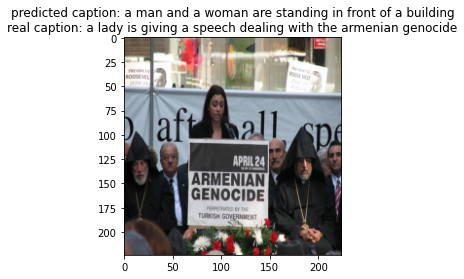

In [109]:
for i in range(15):
  model_notfreeze.eval()
  test_img = torch.clone(i1)[i].unsqueeze(0)
  with torch.no_grad():
    features = model_notfreeze.encoder(test_img[0:1].to(device))
    caps = model_notfreeze.decoder.generate_caption(features.unsqueeze(0),vocab=train_dataset.vocab)
    cap = torch.clone(l1)[i]
    caption_label = [test_dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)  
    caption = "predicted caption: "+ ' '.join(caps[1:len(caps)-1]) + '\n' + "real caption: " + caption_label
    show_image(test_img[0],title=caption)

## compare loss of part A and part B

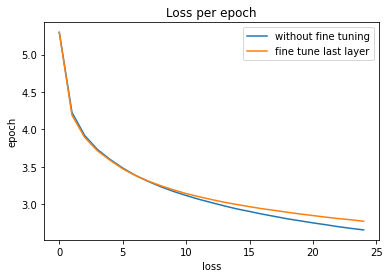

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("loss")
plt.ylabel("epoch")
plt.plot(train_loss, label="without fine tuning")
plt.plot(train_loss_pretrained, label = 'fine tune last layer')
plt.legend()

## part C)

### using a bifirectional LSTM

In [110]:

class LSTM(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True, bidirectional = True)
        self.linear = nn.Linear(hidden_size*2,vocab_size)
        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.dropout(self.embedding(captions[:,:-1]))
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.linear(x)
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.linear(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]
        


### train network for some epochs

In [112]:
# Hyperparameters
embed_size = 128
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 3e-4


In [113]:
# initialize model, loss etc
bidirectional_model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers,train_resnet=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(bidirectional_model.parameters(), lr=learning_rate)

In [ ]:
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()
num_epochs = 25
train_loss_bi = []
for epoch in range(num_epochs):
  running_loss = 0
  #print_examples(model, device, dataset)
  for idx, (image, captions) in enumerate(iter(train_loader)):
    image,captions = image.to(device),captions.to(device)
    bidirectional_model.train()
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
    # Feed forward
      outputs = bidirectional_model(image, captions)
      # Calculate the batch loss.
      loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
      # Backward pass.
      scaler.scale(loss).backward()
    # Update the parameters in the optimizer.
      scaler.step(optimizer) 
      scaler.update() 
      running_loss += loss.item()
  

  
  print(f'epoch: {epoch} -  train loss: {running_loss / (idx+1)} ')
  train_loss_bi.append(running_loss / (idx+1))
  torch.save(bidirectional_model.cpu().state_dict(), 'final_model_bidirectional.pth') # saving model
  bidirectional_model.cuda()

print('training Finished!')

epoch: 0 -  train loss: 4.783764053891589 
epoch: 1 -  train loss: 3.0502734334318786 
epoch: 2 -  train loss: 2.2688607344260583 
epoch: 3 -  train loss: 1.7520939962013617 
epoch: 4 -  train loss: 1.38823200605966 
epoch: 5 -  train loss: 1.122764206432796 
epoch: 6 -  train loss: 0.9261639013990656 
epoch: 7 -  train loss: 0.774204697642293 
epoch: 8 -  train loss: 0.6550377940798139 
epoch: 9 -  train loss: 0.5577171840867796 
epoch: 10 -  train loss: 0.47874367320454203 
epoch: 11 -  train loss: 0.4132322962884303 
epoch: 12 -  train loss: 0.3580444667722795 
epoch: 13 -  train loss: 0.3112681843600907 
epoch: 14 -  train loss: 0.27124994034533734 
epoch: 15 -  train loss: 0.23716422206871993 
epoch: 16 -  train loss: 0.20807426302999885 
epoch: 17 -  train loss: 0.1835923855538135 
epoch: 18 -  train loss: 0.16211946860893622 
epoch: 19 -  train loss: 0.1428779452205538 
epoch: 20 -  train loss: 0.12649830305701368 
epoch: 21 -  train loss: 0.11243175048302938 
epoch: 22 -  train

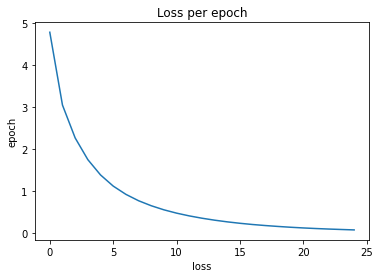

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("loss")
plt.ylabel("epoch")
plt.plot(train_loss_bi)

### test and evaluate model

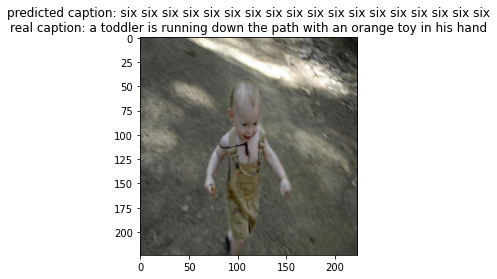

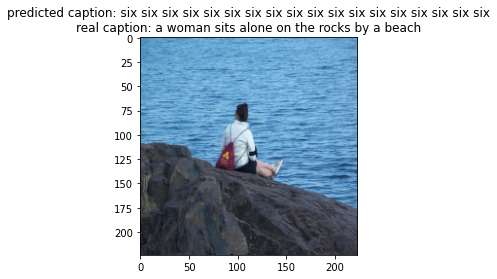

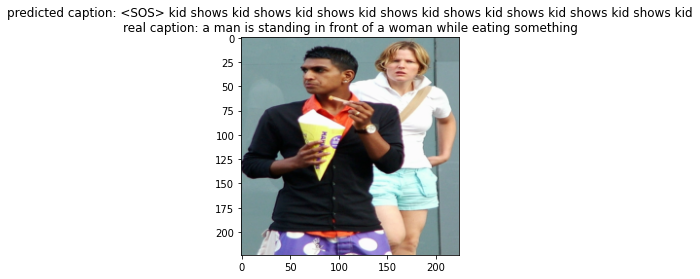

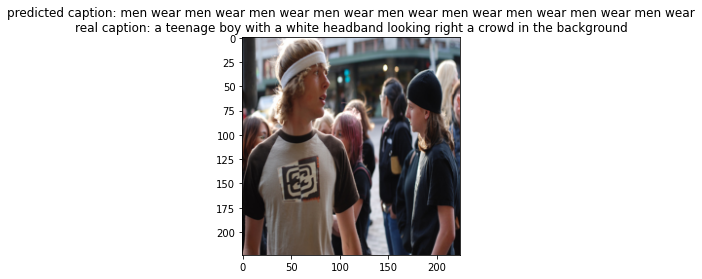

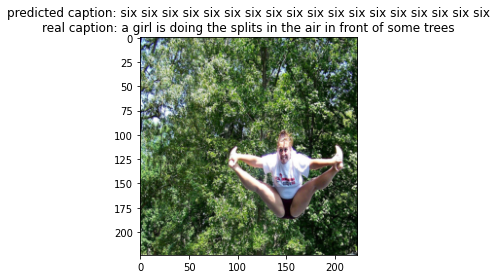

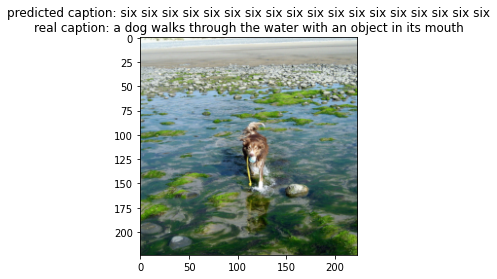

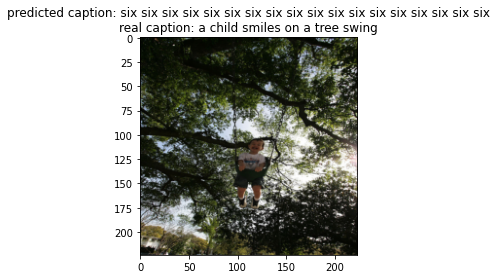

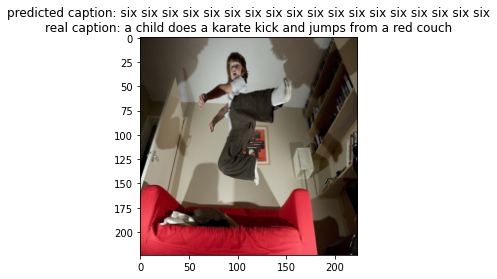

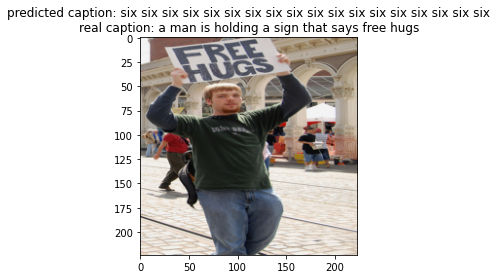

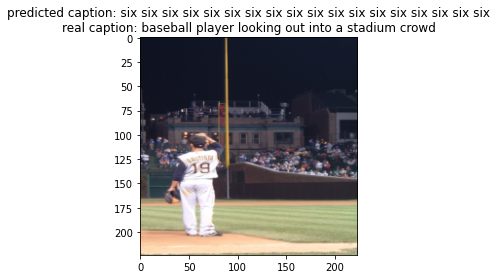

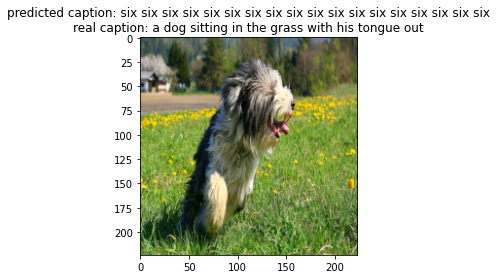

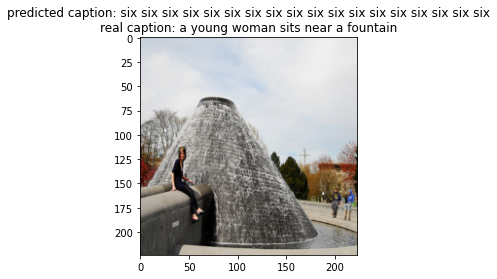

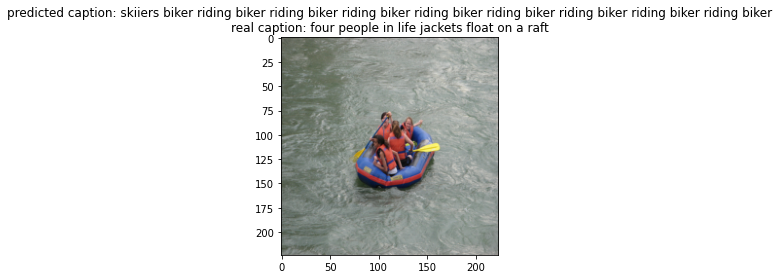

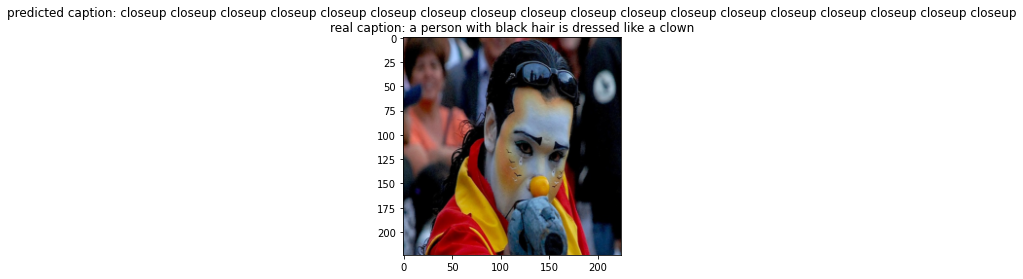

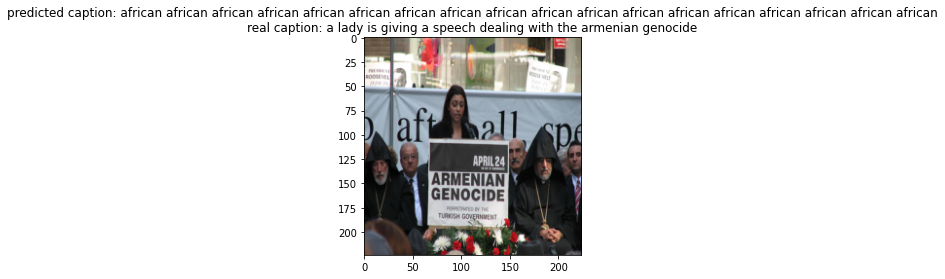

In [116]:
for i in range(15):
  bidirectional_model.eval()
  test_img = torch.clone(i1)[i].unsqueeze(0)
  with torch.no_grad():
    features = bidirectional_model.encoder(test_img[0:1].to(device))
    caps = bidirectional_model.decoder.generate_caption(features.unsqueeze(0),vocab=train_dataset.vocab)
    cap = torch.clone(l1)[i]
    caption_label = [test_dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)  
    caption = "predicted caption: "+ ' '.join(caps[1:len(caps)-1]) + '\n' + "real caption: " + caption_label
    show_image(test_img[0],title=caption)

## compare loss of part A, B and C

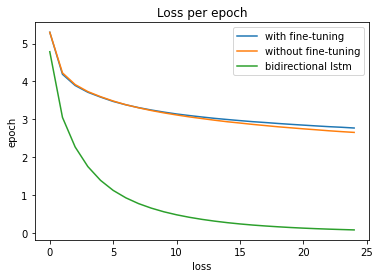

In [121]:
plt.title("Loss per epoch")
plt.xlabel("loss")
plt.ylabel("epoch")
plt.plot(train_loss)
plt.plot(train_loss_train)
plt.plot(train_loss_bi)
plt.legend(['with fine-tuning', 'without fine-tuning', 'bidirectional lstm'])
plt.show()